In [1]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Prelim: generate an OpenMM system from a single methane particle.
Using a single (united atom) methane molecule PBD file to start, then adding solvent and ions with `Modeller`. The secret is to include an xml file (in this directory) containing the mass, atom name, and LJ/charge parameters. These parameters are the same as those used in: 

J. Chem. Phys. 135, 194110 (2011); https://doi.org/10.1063/1.3660669


In [39]:
pdb = PDBFile('single_methane.pdb')
forcefield = ForceField('amber14/tip3pfb.xml', './methane.xml')

modeller=Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(forcefield, padding=2*nanometer)

system = forcefield.createSystem(modeller.topology, nonbondedMethod=CutoffPeriodic,
        nonbondedCutoff=0.8*nanometer, constraints=HBonds)

TEMPERATURE=283*kelvin
PRESSURE = 1*atmosphere
TIMESTEP = 2*femtoseconds

barostat = MonteCarloBarostat(PRESSURE, TEMPERATURE)
system.addForce(barostat)


4

# Prelim: edit the nonbonded forces so that we can alchemically annihilate the LJ particle.

There's a fair bit going on now. Basically we will keep the existing NonbondedForce, but set the epsilon and sigma parameters of the methane particle to zero. This has the effect of removing all nonbonded interactions between water and methane. To reproduce all the interactions that have just been lost, we introduce a CustomNonbondedForce. This force only consists of lennard-jones interactions (since the united atom methane is uncharged), and has an interaction group that restricts it to calculating only the interactions between methane and water. 

Crucially, this custom force has an added parameter - `scalingFactor` - that allows control over the strength of the interactions. This is essentially the `lambda` parameter commonly used in alchemical pertubation papers. At `scalingFactor=1`, all interactions are full strength and the system should behave normally. At `0 < scalingFactor < 1`, the particle is partially annihilated. At `scalingFactor=0`, the particle is completely annihilated.



After defining the function that introduces the new force, we 'simply' create the force objects, add them to the `System` object, and remove the native `NonbondedForce`. 

In [40]:
forces = { force.__class__.__name__ : force for force in system.getForces() }
nbforce = forces['NonbondedForce']

# Add a CustomNonbondedForce to handle only alchemically-modified interactions
alchemical_particles = set([0])
chemical_particles = set(range(system.getNumParticles())) - alchemical_particles


##softcore lennard jones:
#energy_function = 'lambda*4*epsilon*x*(x-1.0); x = (sigma/reff_sterics)^6;'
#energy_function += 'reff_sterics = sigma*(0.5*(1.0-lambda) + (r/sigma)^6)^(1/6);'
#energy_function += 'sigma = 0.5*(sigma1+sigma2); epsilon = sqrt(epsilon1*epsilon2);'

#normal lennard jone:
energy_expression = "sterics;"
energy_expression += "sterics=scalingFactor*4*epsilon*((sigma/r)^12 - (sigma/r)^6);"
energy_expression += "epsilon = sqrt(epsilon1*epsilon2);"
energy_expression += "sigma = 0.5*(sigma1+sigma2);"

custom_force = openmm.CustomNonbondedForce(energy_expression)
custom_force.addGlobalParameter('scalingFactor', 1.0)
custom_force.addPerParticleParameter('sigma')
custom_force.addPerParticleParameter('epsilon')
custom_force.setNonbondedMethod(2)
custom_force.setCutoffDistance(0.8*nanometer)
#custom_force.getUseSwitchingFunction()
custom_force.setForceGroup(1)

for index in range(system.getNumParticles()):
    [charge, sigma, epsilon] = nbforce.getParticleParameters(index)
    custom_force.addParticle([sigma, epsilon])
custom_force.addInteractionGroup(alchemical_particles, chemical_particles)
system.addForce(custom_force)


5

In [41]:
#set the parameters for methane in the original nonbondedforce to zero:
nbforce.setParticleParameters(0, 0*elementary_charge, 0*nanometer, 0*kilojoules_per_mole)

In [42]:
#finally, create the Simulation object:

integrator = LangevinIntegrator(TEMPERATURE, 1/picosecond, TIMESTEP)
platform = Platform.getPlatformByName('OpenCL')
prop = {'OpenCLPrecision':'single'}

simulation = Simulation(modeller.topology, system, integrator, platform, prop)
simulation.context.setPositions(modeller.positions)
simulation.context.setVelocitiesToTemperature(TEMPERATURE)

PDBFile.writeFile(modeller.topology, modeller.positions, file=open('methane.pdb', 'w'))
simulation.reporters.append(DCDReporter('methane.dcd', 1000))


simulation.minimizeEnergy()


print('energy is:', simulation.context.getState(getEnergy=True).getPotentialEnergy())

energy is: -119998.61239229504 kJ/mol


# Prelim: run a short equilibration:


In [44]:
pes = list()
group_p=list()
vol = list()
for _ in tqdm.tqdm_notebook(range(2000)):
    simulation.step(100)
    state = simulation.context.getState(getEnergy=True)
    pe = state.getPotentialEnergy()
    v = state.getPeriodicBoxVolume()    
    pes.append(pe)
    vol.append(v)
    
    
    state = simulation.context.getState(getEnergy=True, groups={1})
    p = state.getPotentialEnergy()
    group_p.append(p)

/home/lewis/miniconda3/envs/scra_cb1/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


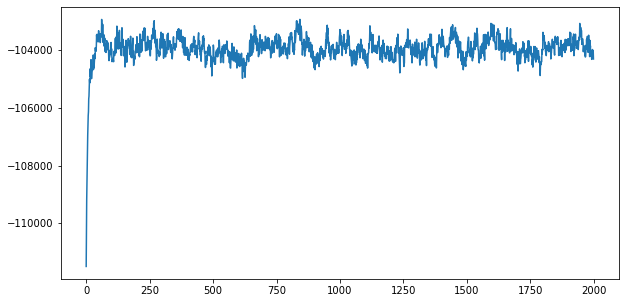

In [45]:
fig, ax = plt.subplots()

fig.set_figwidth(10)
fig.set_figheight(5)

ax.plot([i/kilojoule*mole for i in pes])

#we check visually that it's equilibrated, and can then save the positions and velocities. 
state = simulation.context.getState(getPositions=True, getVelocities=True)
equilibrated_positions = state.getPositions()
equilibrated_velocities = state.getVelocities()

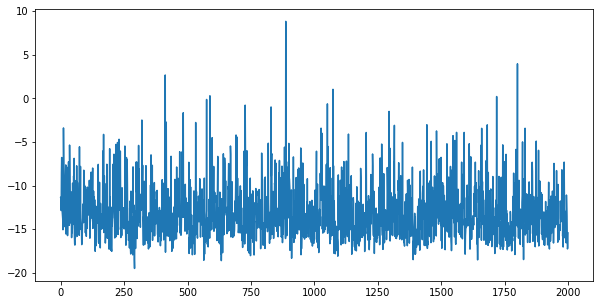

In [46]:
#plot just the energy of the methane nonbonded interactions:
fig, ax = plt.subplots()

fig.set_figwidth(10)
fig.set_figheight(5)

ax.plot([i/kilojoule*mole for i in group_p])

# Estimate weights (free energy) for alchemical annihilation

This is equivalent to estimating the chemical potential of methane in this system. 

In [47]:
def scaling_function(simulation, level):
    simulation.context.setParameter('scalingFactor', level)
    
    
from gsst import GSST
levels = np.linspace(1,0,10)
levels = [1,0.75, 0.5, 0.3, 0.1, 0.05, 0.01,0.005,0.001, 0]
st = GSST(simulation=simulation, 
                              scaling_function=scaling_function,
                             levels=levels, 
                              changeInterval=1500,
                              cutoff=1e-6,
                              baseTemp=298*kelvin,
                              reportFile='methane.dat'
                             )

In [49]:
for level in levels:
    scaling_function(simulation, level)
    state = simulation.context.getState(getEnergy=True).getPotentialEnergy()
    print(state)

-104310.20293020738 kJ/mol
-104306.34355520738 kJ/mol
-104302.49199270738 kJ/mol
-104299.40605520738 kJ/mol
-104296.32011770738 kJ/mol
-104295.55449270738 kJ/mol
-104294.92949270738 kJ/mol
-104294.85136770738 kJ/mol
-104294.78886770738 kJ/mol
-104294.77324270738 kJ/mol


In [53]:
print('Progress towards cutoff\nleft:_weightUpdateFactor=1;\nright:_weightUpdateFactor=1e-8')
while st._weightUpdateFactor>1e-6:
    simulation.step(1500)
 #   print(st.currentLevel, st._weightUpdateFactor, st._weights)
    
    #homemade progress bar:
    fraction = np.abs(np.log10(st._weightUpdateFactor)/6)
    print('|' + ' '*int((100*fraction)) + '*' + ' '*int(100*(1-fraction)) + '|', end='\r')
print('Finished')

Progress towards cutoff
left:_weightUpdateFactor=1;
right:_weightUpdateFactor=1e-8
Finished


# Now estimate the chemical potential using MBAR

In [54]:
simulation.reporters.pop()
simulation.context.setPositions(equilibrated_positions)
simulation.context.setVelocities(equilibrated_velocities)



# Collect data
nsteps = 1500 # number of steps inbetween sampling the potential energy
niterations = 300 # number of samples to collect at each separation distance. 

#reverse the levels, since we don't want to sample for a long time at the annihilated state and then 
#accidentally bring the particle back into existence on top of a water molecule.

nstates = len(levels)
u_kln = np.zeros([nstates,nstates,niterations], np.float64)
kT = AVOGADRO_CONSTANT_NA * BOLTZMANN_CONSTANT_kB * simulation.integrator.getTemperature()

for k in tqdm.notebook.tqdm(range(nstates)):
    for iteration in tqdm.notebook.tqdm(range(niterations)):
        # Set the separation distance:
        scaling_function(simulation, levels[k])
        # Sample in MD-space for a bit:
        simulation.step(nsteps)
        # Compute what the energy of the current configuration would be at ALL separations,
        # this is used to calculate energetic overlap between the states. 
        for l in range(nstates):
            scaling_function(simulation, levels[l])
            u_kln[k,l,iteration] = simulation.context.getState(getEnergy=True).getPotentialEnergy() / kT
            
levels = levels[::-1]

In [55]:
# Estimate free energy of Lennard-Jones particle insertion
from pymbar import MBAR, timeseries
# Subsample data to extract uncorrelated equilibrium timeseries
N_k = np.zeros([nstates], np.int32) # number of uncorrelated samples
for k in range(nstates):
    [nequil, g, Neff_max] = timeseries.detectEquilibration(u_kln[k,k,:])
    indices = timeseries.subsampleCorrelatedData(u_kln[k,k,:], g=g)
    N_k[k] = len(indices)
    u_kln[k,:,0:N_k[k]] = u_kln[k,:,indices].T
# Compute free energy differences and statistical uncertainties
mbar = MBAR(u_kln, N_k)
[DeltaF_ij, dDeltaF_ij,] = mbar.getFreeEnergyDifferences()


In [56]:
# save the outputs if you want to replot later:
np.save('u_kln_methane_mbar.npy', u_kln)

# Plot the difference

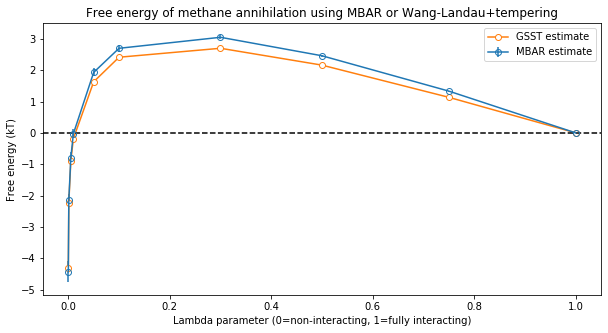

In [57]:
plt.figure(figsize=(10,5))

plt.errorbar(x=levels[::-1], 
             y=DeltaF_ij[0], 
             yerr = dDeltaF_ij[0], fmt='-o', mfc='none', label='MBAR estimate')

plt.plot(levels[::-1], 
             st.weights, '-o', mfc='white',label='GSST estimate')

plt.title('Free energy of methane annihilation using MBAR or Wang-Landau+tempering')
plt.legend()
plt.ylabel('Free energy (kT)')
plt.xlabel('Lambda parameter (0=non-interacting, 1=fully interacting)')
plt.axhline(0, linestyle='--', c='k')

plt.savefig('chemical_potential.png')